# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the data

In [2]:
credits = pd.read_csv('../Dataset/scores.csv')
encoded_applications = pd.read_csv('../Dataset/processed_applications.csv')

# Adjust Data
Splitting data

In [3]:
updated_applicants = pd.merge(encoded_applications, credits, on='id', how='left')
updated_applicants = updated_applicants.drop(['id'], axis=1)

applicants_w_records = updated_applicants.dropna(subset = ["total_score"])
applicants_no_records = updated_applicants.loc[updated_applicants["total_score"].isna()]

We split away around 20% of the applicants with records as test data.

In [4]:
removal_index_labeled = range(0, len(applicants_w_records), 5)
test_data = applicants_w_records.reset_index().filter(removal_index_labeled, axis=0)
train_data = applicants_w_records.reset_index().drop(removal_index_labeled, axis=0)

x_test_data = test_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1)
y_test_data = test_data['total_score']
x_train_data = train_data.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1)
y_train_data = train_data['total_score']

We split the unlabelled data into 3 sets.

In [5]:
removal_index_unlabelled1 = range(0, len(applicants_no_records), 3)
removal_index_unlabelled2 = range(1, len(applicants_no_records), 3)
removal_index_unlabelled3 = range(2, len(applicants_no_records), 3)
unlabelled_data_1 = applicants_no_records.reset_index().filter(removal_index_unlabelled1, axis=0)
unlabelled_data_2 = applicants_no_records.reset_index().filter(removal_index_unlabelled2, axis=0)
unlabelled_data_3 = applicants_no_records.reset_index().filter(removal_index_unlabelled3, axis=0)

x_unlabelled_data_1 = unlabelled_data_1.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1)
x_unlabelled_data_2 = unlabelled_data_2.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1)
x_unlabelled_data_3 = unlabelled_data_3.drop(['credit_history_score', 'duration_score', 'total_score'], axis=1)

We remove first column as they are indexes.

In [6]:
x_test_data = x_test_data.drop(columns=['index'])
x_train_data = x_train_data.drop(columns=['index'])
x_unlabelled_data_1 = x_unlabelled_data_1.drop(columns=['index'])
x_unlabelled_data_2 = x_unlabelled_data_2.drop(columns=['index'])
x_unlabelled_data_3 = x_unlabelled_data_3.drop(columns=['index'])

# Semi-supervised Learning
We will now use the learning model and implement Random Forest.

Datasets:
* x_test_data
* y_test_data
* x_train_data
* y_train_data
* x_unlabelled_data_1
* x_unlabelled_data_2
* x_unlabelled_data_3

scores >= 0.35 is the threshold for good clients.

In [7]:
y_test_data = (y_test_data > 0.35).astype(int)
y_train_data = (y_train_data > 0.35).astype(int)

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_data, y_train_data = oversample.fit_resample(x_train_data, y_train_data)

In [8]:
from sklearn.metrics import accuracy_score
trg_num = [1, 2, 3, 4]
accuracy_scores = []

In [9]:
from sklearn.ensemble import RandomForestClassifier
model_one = RandomForestClassifier(criterion="entropy")
model_two = RandomForestClassifier(criterion="entropy")
model_three = RandomForestClassifier(criterion="entropy")
model_four = RandomForestClassifier(criterion="entropy")

## First training

In [10]:
first_training = model_one.fit(x_train_data, y_train_data)

In [11]:
generated_label_1 = model_one.predict(x_unlabelled_data_1)
generated_label_1 = pd.Series(generated_label_1, name='total_score', dtype=float)
new_x_train_data = pd.concat([x_train_data, x_unlabelled_data_1])
new_y_train_data = pd.concat([y_train_data, generated_label_1])

In [12]:
test1_accuracy = model_one.predict(x_test_data)
test1_accuracy = pd.Series(test1_accuracy, name='total_score', dtype=float)
accuracy_scores.append(accuracy_score(y_test_data, test1_accuracy))

## Second training 

In [13]:
second_training = model_two.fit(new_x_train_data, new_y_train_data)

In [14]:
generated_label_2 = model_two.predict(x_unlabelled_data_2)
generated_label_2 = pd.Series(generated_label_2, name='total_score', dtype=float)
new_x_train_data = pd.concat([new_x_train_data, x_unlabelled_data_2])
new_y_train_data = pd.concat([new_y_train_data, generated_label_2])

In [15]:
test2_accuracy = model_two.predict(x_test_data)
accuracy_scores.append(accuracy_score(y_test_data, test2_accuracy))

## Third training

In [16]:
third_training = model_three.fit(new_x_train_data, new_y_train_data)

In [17]:
generated_label_3 = model_three.predict(x_unlabelled_data_3)
generated_label_3 = pd.Series(generated_label_3, name='total_score', dtype=float)
new_x_train_data = pd.concat([new_x_train_data, x_unlabelled_data_3])
new_y_train_data = pd.concat([new_y_train_data, generated_label_3])

In [18]:
test3_accuracy = model_three.predict(x_test_data)
accuracy_scores.append(accuracy_score(y_test_data, test3_accuracy))

# Fourth training 

In [19]:
fourth_training = model_four.fit(new_x_train_data, new_y_train_data)

## Testing accuracy
We will now test the accuracy of our model.

In [20]:
from sklearn.metrics import classification_report

In [21]:
test4_accuracy = model_four.predict(x_test_data)
accuracy_scores.append(accuracy_score(y_test_data, test4_accuracy))
test4_accuracy = pd.Series(test4_accuracy, name='total_score', dtype=float)
print(classification_report(y_test_data, test4_accuracy))

              precision    recall  f1-score   support

           0       0.30      0.35      0.32       420
           1       0.96      0.95      0.95      6872

    accuracy                           0.91      7292
   macro avg       0.63      0.65      0.64      7292
weighted avg       0.92      0.91      0.92      7292



What if we simply do RF on the labelled data only?

In [22]:
pure_model_accuracy = model_one.predict(x_test_data)
pure_model_accuracy = pd.Series(pure_model_accuracy, name='total_score', dtype=float)
print(classification_report(y_test_data, pure_model_accuracy))

              precision    recall  f1-score   support

           0       0.30      0.37      0.33       420
           1       0.96      0.95      0.95      6872

    accuracy                           0.91      7292
   macro avg       0.63      0.66      0.64      7292
weighted avg       0.92      0.91      0.92      7292



What are the accuracies of all 4 training iterations in SSL?

In [23]:
accuracy_scores

[0.914289632473944, 0.9141524958859023, 0.9162095447065277, 0.9149753154141524]

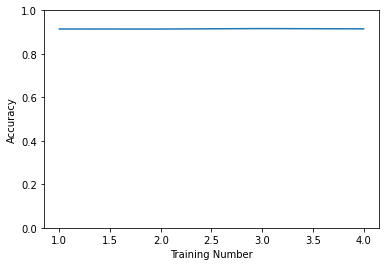

In [24]:
plt.plot(trg_num, accuracy_scores)
plt.xlabel('Training Number') 
plt.ylabel('Accuracy') 
plt.ylim(0,1)
plt.show() 